# Foundation

In [1]:
# Standard library imports
from collections import OrderedDict as od
from glob import glob
from importlib import reload
import inspect
import itertools
import os
import os.path as op
import random
import sys
from time import time
import warnings

# Third party imports
import h5py
import matplotlib as mpl # plotting
from matplotlib.lines import Line2D # plotting
import matplotlib.patches as patches # plotting
import matplotlib.pyplot as plt # plotting
import matplotlib.gridspec as gridspec  # plotting
import numpy as np # functions to analyze and manipulate arrays & matrices
import pandas as pd # dataframes
import scipy.interpolate as interp # scientific computation 
import scipy.io as sio # scientific computation 
import scipy.stats as stats # scientific computation 
import scipy.ndimage as ndi
import seaborn as sns # plotting
from sklearn.decomposition import PCA # tools for machine learning and statistical modeling. Useful for predictions of unobserved values.
import statsmodels.api as sm # tools for statistical analysis. Useful for statistical inference and statistical hypothesis testing.
from statsmodels.formula.api import ols

# Local application imports
sys.path.append('/home1/cjmac/code/general')
sys.path.append('/home1/cjmac/code/manning_replication')
sys.path.append('/home1/cjmac/code/projects/')
import array_operations as aop # for coding
import data_io as dio # for coding
from eeg_plotting import plot_trace, plot_trace2 #plotting
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, trial_phase_analysis # processing eeg data

# Initializing commands
%matplotlib inline
warnings.filterwarnings( 'ignore' )
pd.options.display.max_rows = 500
pd.options.display.max_columns = 999

# Plotting parameters
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42
# warnings.filterwarnings( 'default' )

# Plotting colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)
# Plotting font
font = {'tick': 12,
        'label': 14,
        'fig': 16}

In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

# Event Alignment

In [2]:
subj_sess = 'U554_ses0'

# Load the sync channel.
# sync_chan = events_preproc.load_syncs(subj_sess, data_key='data')
sync_chan, TTL, timestamp_flag = events_preproc.load_syncs(subj_sess, data_key='data')

from importlib import reload
import spike_preproc
flag_reload = 1
if flag_reload:
    reload( events_preproc )

if not timestamp_flag: 
     
    # Read events file and get event synctimes.
    events, event_synctimes = events_preproc.read_events_json( subj_sess )

    # Load LFP timestamps.
    lfp_timestamps, sr = spike_sorting.load_lfp_timestamps( subj_sess )

    # Identify sync pulses in the sync channel EEG.
    pulse_startinds = events_preproc.find_pulse_starts(sync_chan, 
                                                   sampling_rate=sr, 
                                                   pulse_thresh=200, 
                                                   intrapulse_thresh_ms=20, 
                                                   interpulse_thresh_ms=790)
    
    lfp_synctimes = lfp_timestamps[pulse_startinds]
    print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

    subj, sess = subj_sess.split('_')
    sync_f = os.path.join('/home1/cjmac/projects/time_cells', 'data', subj, sess, 'sync', 'sync_channel_micro.mat')


    # Find matching sync pulse pairs.
    event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                             lfp_synctimes, step=5, max_shift=200, max_slide=50, ipi_thresh=2)
    # Perform the alignment.
    alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                                 lfp_synctimes_adj)
    
    # Apply the alignment to all event times.
    events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))    
    
else:    
    # Read events file and get event synctimes in msec.
    events, event_synctimes = events_preproc.read_events_json( subj_sess, start_at_zero = True  )

    
    # Load LFP timestamps in msec
    lfp_timestamps, sr = spike_sorting.load_lfp_timestamps( subj_sess, start_at_zero = True, conv_factor = 'infer' )

    sync_chan_new = sync_chan
    sync_chan_new = sync_chan_new - sync_chan[0] 
    sync_chan_new *= 1000 ; # converts to msec
    TTL_new = TTL
    TTL_new[ np.where( TTL != 255) ] = 0
    from scipy import interpolate
    f = interpolate.interp1d(sync_chan_new, TTL_new, kind = 'next', fill_value='extrapolate')
    TTL_up = f( lfp_timestamps ) 
    
    plot_flag = 0
    if plot_flag:
        ind_range_1 = [ 0, 100000 ] 
        fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=300)
        plt.plot(lfp_timestamps[ slice( ind_range_1[0], ind_range_1[1], 1)], 
                 TTL_up[ slice( ind_range_1[0], ind_range_1[1], 1)],
                 marker = 'o', color = 'blue', linestyle = 'none', markersize = 8 )
    
    pulse_startinds = np.where( TTL_up == 255)[0] 
    lfp_synctimes = lfp_timestamps[pulse_startinds]
    
    # 
    plot_flag = 0
    if plot_flag:
        time_range = [ 30000, 100000 ] 
        ind_lfp_synctimes = np.where(np.logical_and(lfp_synctimes>=time_range[0], lfp_synctimes<=time_range[1]))
        ind_event_synctimes= np.where(np.logical_and(event_synctimes>=time_range[0], event_synctimes<=time_range[1]))
        fig, ax = plt.subplots(1, 1, figsize=(30, 10), dpi=300)
        plt.plot(lfp_synctimes[ ind_lfp_synctimes ], 
                 np.full( ( 1, len( ind_lfp_synctimes[0] ) ), 255 )[0],
                 marker = 'o', color = 'blue', linestyle = 'none', markersize = 16 ) 
        plt.plot(event_synctimes[ ind_event_synctimes ], 
                 np.full( ( 1, len( ind_event_synctimes[0] ) ), 255 )[0],
                 marker = 'x', color = 'red', linestyle = 'none', mew = 4, markersize = 16 ) 
        plt.show()        

    print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

    subj, sess = subj_sess.split('_')
    sync_f = os.path.join('/home1/cjmac/projects/time_cells', 'data', subj, sess, 'sync', 'sync_channel_micro.mat')
    
    # Find matching sync pulse pairs.
    event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                             lfp_synctimes, step=5, max_shift=200, max_slide=50, ipi_thresh=2)
    
    # Perform the alignment.
    alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                                 lfp_synctimes_adj)

    # Apply the alignment to all event times.
    events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))

The first timestamp in events before zero-ing is 1654735168087.340
The first timestamp in events after zero-ing is 0.000
143295 events recorded over 78 min and 57 sec
The first timestamp in lfp_timestamps before zero-ing & before conv factor is 1654709925.092
The first timestamp in lfp_timestamps before zero-ing & after conv factor is 1654709925091.791
The first timestamp in lfp_timestamps after zero-ing & conv factor is 0.000
Conversion factor is 1000.0
153210591 timestamps over 79 min and 47.8 s
Sampling rate is 32000 Hz
Detected 6082 syncs for 4732 sync pulse events
Loop 1: Inter-sync times failed to converge
Loop 8: Inter-sync times failed to converge
Loop 11: Inter-sync times failed to converge
Loop 12: Inter-sync times failed to converge
Loop 23: Inter-sync times failed to converge
Loop 24: Inter-sync times failed to converge
Loop 32: Inter-sync times failed to converge
Loop 40: Inter-sync times failed to converge
Loop 48: Inter-sync times failed to converge
Loop 61: Inter-sync t

# Create events data frame and remove bad trials

In [3]:
from importlib import reload
import spike_preproc
flag_reload = 1
if flag_reload:
    reload( events_preproc )

proc_events = 1
proc_spikes = 1
proj_dir = '/home1/cjmac/projects/time_cells'
run_all = True
save_output = True
overwrite = False
verbose = True

start_time = time()
warnings.filterwarnings('ignore')

if proc_events:
    # Load events and event times.
    print('Processing events data.', end='\n\n')
    events = events_preproc.format_events(events=events,
                                          noisy_trials=[],
                                          remove_incomplete_trials=True,
                                          remove_noisy_trials=False,
                                          remove_paused_trials=False,
                                          overwrite=overwrite,
                                          save_output=save_output,
                                          proj_dir=proj_dir,
                                          verbose=verbose)

Processing events data.

Found formatted events dataframe


# Create a table for the Study phase

In [4]:
# create dataframe by unnesting all item (key:value) pairs
all_value = pd.DataFrame( events.value.tolist() )
# create a boolean index for events based on whether gameState = Encoding
isEncoding = np.where(events['gameState'] == 'Encoding', True, False ) 
# create a boolean index for masking. get all dataframe entries where key = pickup
isPickup = np.where(events['key'] == 'pickup', True, False ) 
#
isSuccessful = all_value.successful
#
isEncodingPickup = np.logical_and( isEncoding, isPickup )
isEncodingPickup = np.logical_and(isEncodingPickup, isSuccessful )
#
events_study = events[isEncodingPickup]
events_study = events_study.reset_index(drop=True)
#
nearestItemName = pd.DataFrame( events_study.value.tolist() ).nearestItemName
#
events_study.insert( 5, 'gem', nearestItemName )
#
events_study = events_study.drop( { 'time', 'key', 'value', 'scene', 'time_penalty', 'bad_trials' }, axis = 1 )

events_study = events_study.rename( { 'trial':'list', 'gem':'item', 'gameState':'trial_type' }, axis= 'columns' )
events_study['trial_type'] = events_study['trial_type'].str.replace( 'Encoding', 'study' )
events_study['position'] = events_study.groupby( 'list' ).cumcount() + 1
events_study = events_study.iloc[:, [0, 2, 3, 1 ] ]
events_study.insert(0, 'subject', 1 )
events_study.insert(5 , 'category', 'gems' )
events_study.insert(5 , 'list_type', 'pure'  )

# Create a table for the Recall phase

In [5]:
# create dataframe by unnesting all item (key:value) pairs
all_value = pd.DataFrame( events.value.tolist() )
# get each trial's timeline info
timelines = list( all_value.loc[all_value.chosenTimelineItems.notna().values].chosenTimelineItems )
#
events_recall = [ ( trial, chosengem ) for trial, gem in enumerate( timelines ) for chosengem in gem ]
#
events_recall = pd.DataFrame( events_recall, columns=['trial', 'chosengems_all' ] )
chosengems_all = pd.DataFrame( events_recall.chosengems_all.tolist() )
#
events_recall = pd.concat( [events_recall, chosengems_all ], axis = 1  )
#
events_recall = events_recall.drop( { 'chosengems_all', 'actualTime' }, axis = 1 )

events_recall.drop_duplicates(keep='last' )
events_recall['trial'] = events_recall['trial'] + 1

events_recall = events_recall.drop_duplicates(keep = 'last' )

events_recall = events_recall[ events_recall.chosenTime > 0 ]

events_recall['chosenTime'] = events_recall.groupby( 'trial' ).cumcount() + 1
events_recall[ 'trial_type' ] = 'recall'
events_recall = events_recall.rename( { 'trial':'list', 'name':'item', 'chosenTime':'position' }, axis= 'columns' )
events_recall = events_recall.iloc[:, [0, 3, 2, 1 ] ]
events_recall.insert(0, 'subject', 1 )
events_recall.insert(5 , 'category', 'gems' )
events_recall.insert(5 , 'list_type', 'pure'  )

In [6]:
raw = pd.concat( [ events_study, events_recall ] )
data = fr.merge_free_recall( raw )

# Make a pretty heat plot

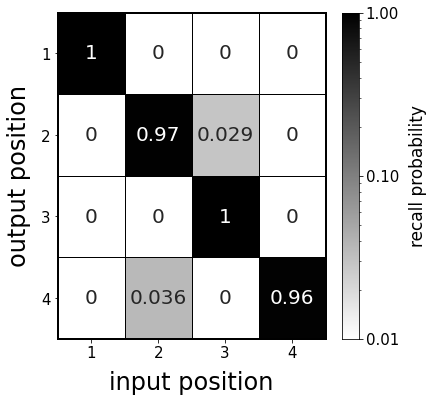

In [53]:
tab00 = pd.crosstab(data.input, data.output, normalize = 'index')
fig00, ax00 = plt.subplots(figsize=(6, 6), ncols=1 )
cmap00 = plt.get_cmap('binary')
sns.heatmap(tab00.values,\
            annot=True,\
            cmap = cmap00,\
            annot_kws={"size": 20 },\
            norm = mpl.colors.LogNorm( vmin = 0.01, vmax = 1, clip=True ),\
            cbar_kws = {"format": mpl.ticker.ScalarFormatter() },\
            clip_on  = False,\
            linecolor = 'k',\
            linewidth = 1,\
            xticklabels = [1, 2, 3, 4],\
            yticklabels = [1, 2, 3, 4],\
            ax=ax00)
#
plt.yticks( axes = ax00, rotation = 0)
ax00.set_ylabel('output position', size=24)
ax00.set_xlabel('input position', size=24 )
# make the heatplot axes boundary visible bc by default it is not
ax00.spines[:].set_visible( True )
# thicken the heatplot axes boundary
ax00.spines[:].set_linewidth( 2 )
# make the colorbar axes boundary visible bc by default it is not
fig00.axes[-1].spines[:].set_visible( True )
fig00.axes[-1].set_ylabel('recall probability')
# 
plt.savefig('test01.eps', dpi=300)

# Make a pretty lineplot with a break in the y axis

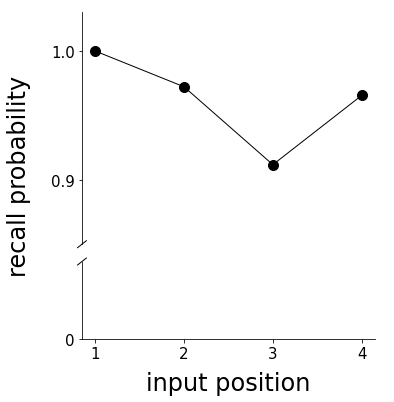

In [52]:
# #
recprob = data.groupby([ "input"],dropna=True)["recall"].mean()
# #
fig00, (ax00, ax01) = plt.subplots(2, 1, sharex=True, figsize=(6, 6),gridspec_kw={'height_ratios': [3, 1]})
# #
ax00.plot(recprob.index, recprob.values, marker = 'o', markersize = 10, c = 'k')
ax01.plot(recprob.index, recprob.values)
# ax00.plot(recprob)
# zoom-in / limit the view to different portions of the data
ax00.set_ylim(.85, 1.03)  # all of the data
ax01.set_ylim(0, .25)  
# # hide the spines between ax00 and ax01
ax00.spines['bottom'].set_visible(False)
ax01.spines['top'].set_visible(False)
ax00.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off    top
#
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax00.transAxes, color='k', clip_on=False)
# ax00.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax00.plot((-d, +d), (-d, +d), **kwargs) 
#
kwargs.update(transform=ax01.transAxes)  # switch to the bottom axes
ax01.plot((-d, +d), (1 - 3*d, 1 + 3*d), **kwargs)  # bottom-left diagonal
#
ax00.set_yticks([0.9, 1.0])
ax01.set_yticks([0])
ax01.set_xticks([1, 2, 3, 4])
ax01.set_xlabel('input position', size = 24)
#
# Create a big subplot
ax02 = fig00.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
ax02.tick_params(
    axis = 'both',
    which = 'both',
    bottom = False,
    top = False,
    left = False,
    labelcolor = 'none')
ax02.set_ylabel('recall probability', size=24, labelpad=20)
plt.tight_layout()
plt.savefig('test00.eps', dpi=300)


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((3, 5), (1,5), color='black')
plt.show()

In [ ]:
help( fr.plot_raster )

In [ ]:
from psifr import fr

data = fr.merge_lists( events_study, events_recall ) 

print( data )


# df2 = fr.merge_free_recall(df1, list_keys=["list_type"], study_keys=["category"])